# 사용하는 라이브러리

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.losses import Huber
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.callbacks import  ModelCheckpoint, EarlyStopping

# 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df_ETH = pd.read_csv('gdrive/My Drive/Colab Notebooks/데이터/KRW-ETH.csv', encoding='utf8')
df_ETH.columns = ['일자', '시가', '고가', '저가', '종가', '거래수', '거래량']
df_ETH['일자'] = pd.to_datetime(df_ETH['일자'], format='%Y-%m-%d')

df_BTC = pd.read_csv('gdrive/My Drive/Colab Notebooks/데이터/KRW-BTC.csv', encoding='utf8')
df_BTC.columns = ['일자', '시가', '고가', '저가', '종가', '거래수', '거래량']
df_BTC['일자'] = pd.to_datetime(df_BTC['일자'], format='%Y-%m-%d')

df_ADA = pd.read_csv('gdrive/My Drive/Colab Notebooks/데이터/KRW-ADA.csv', encoding='utf8')
df_ADA.columns = ['일자', '시가', '고가', '저가', '종가', '거래수', '거래량']
df_ADA['일자'] = pd.to_datetime(df_ADA['일자'], format='%Y-%m-%d')

df_XRP = pd.read_csv('gdrive/My Drive/Colab Notebooks/데이터/KRW-XRP.csv', encoding='utf8')
df_XRP.columns = ['일자', '시가', '고가', '저가', '종가', '거래수', '거래량']
df_XRP['일자'] = pd.to_datetime(df_XRP['일자'], format='%Y-%m-%d')

max_ETH = df_ETH['종가'].max()

Text(0, 0.5, 'Value')

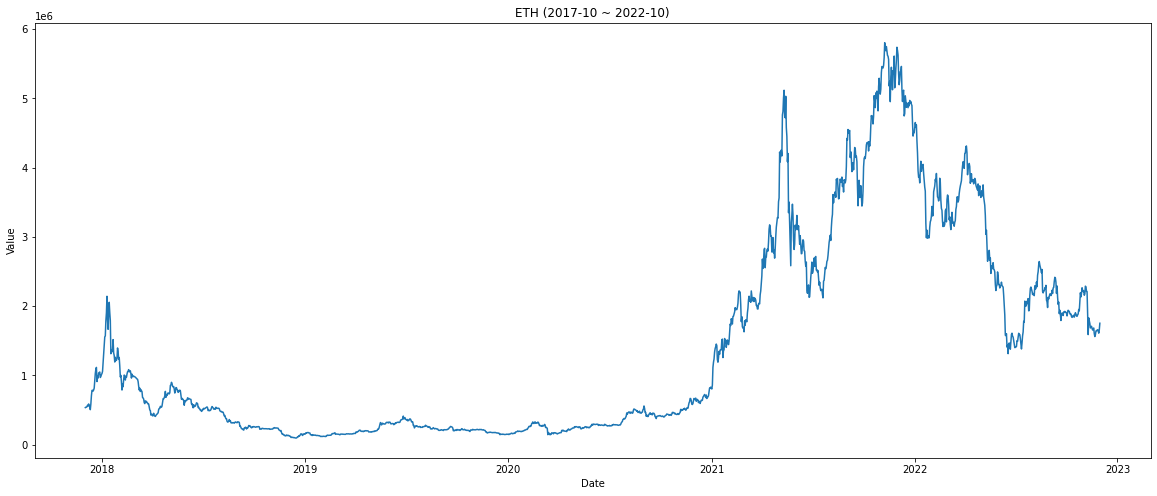

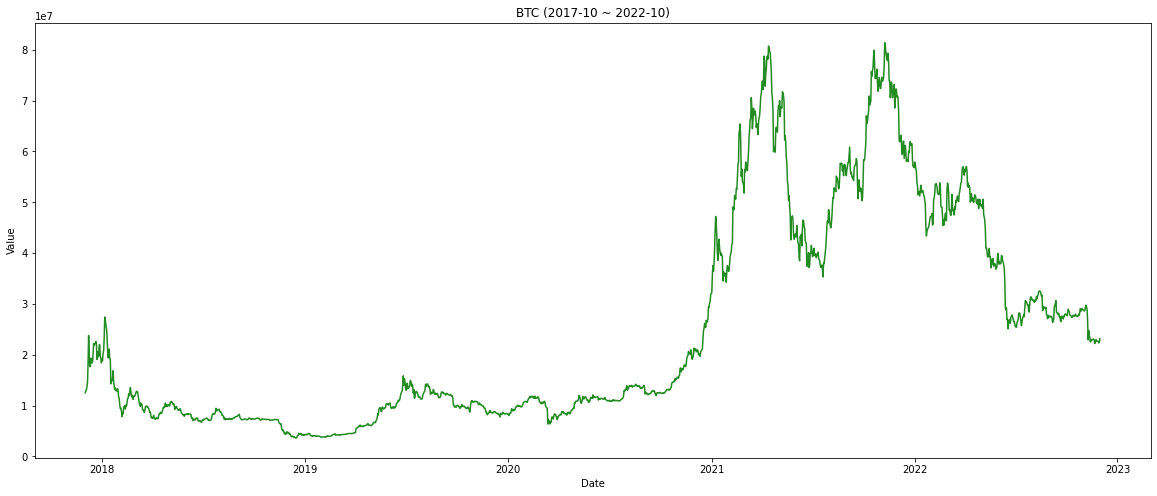

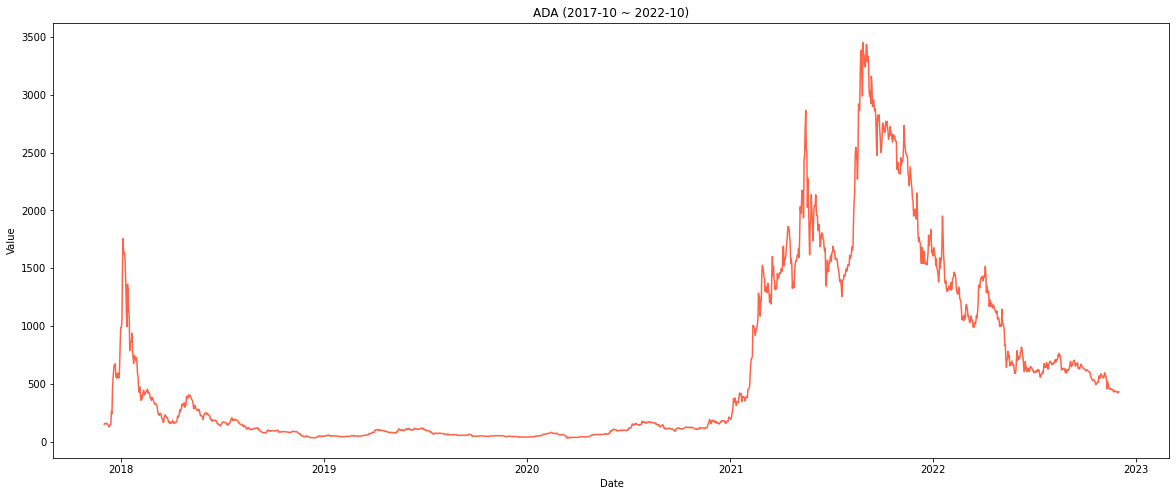

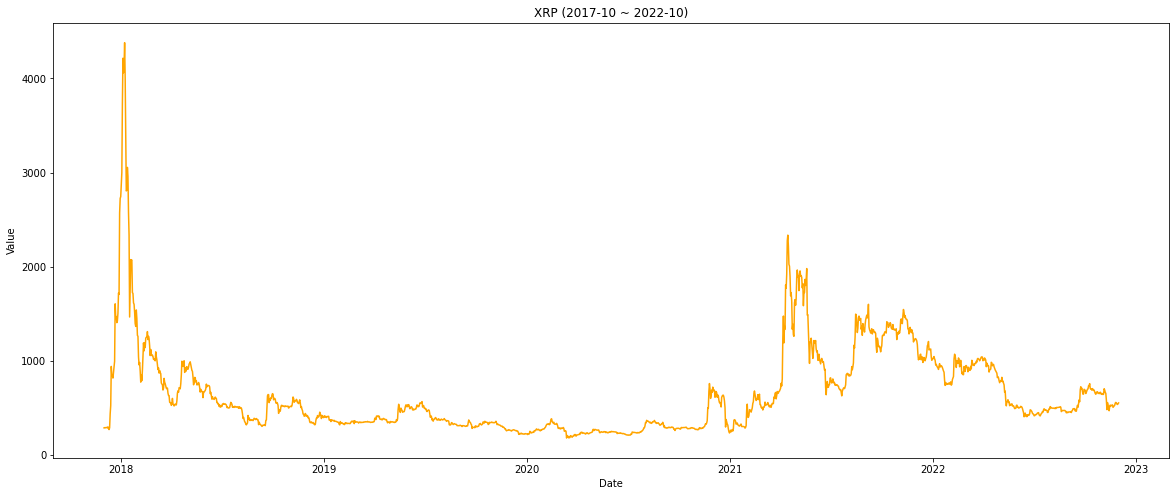

In [4]:
plt.figure(figsize=(20,8))
plt.plot(df_ETH['일자'], df_ETH['종가'])
plt.title('ETH (2017-10 ~ 2022-10)')
plt.xlabel('Date')
plt.ylabel('Value')

plt.figure(figsize=(20,8))
plt.plot(df_BTC['일자'], df_BTC['종가'], color = 'forestgreen')
plt.title('BTC (2017-10 ~ 2022-10)')
plt.xlabel('Date')
plt.ylabel('Value')

plt.figure(figsize=(20,8))
plt.plot(df_ADA['일자'], df_ADA['종가'], color = 'tomato')
plt.title('ADA (2017-10 ~ 2022-10)')
plt.xlabel('Date')
plt.ylabel('Value')

plt.figure(figsize=(20,8))
plt.plot(df_XRP['일자'], df_XRP['종가'], color = 'orange')
plt.title('XRP (2017-10 ~ 2022-10)')
plt.xlabel('Date')
plt.ylabel('Value')

# 데이터셋 생성

## 데이터 정규화

In [5]:
scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래수', '거래량']
df_ETH[scale_cols] = scaler.fit_transform(df_ETH[scale_cols])

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래수', '거래량']
df_BTC[scale_cols] = scaler.fit_transform(df_BTC[scale_cols])

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래수', '거래량']
df_ADA[scale_cols] = scaler.fit_transform(df_ADA[scale_cols])

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래수', '거래량']
df_XRP[scale_cols] = scaler.fit_transform(df_XRP[scale_cols])

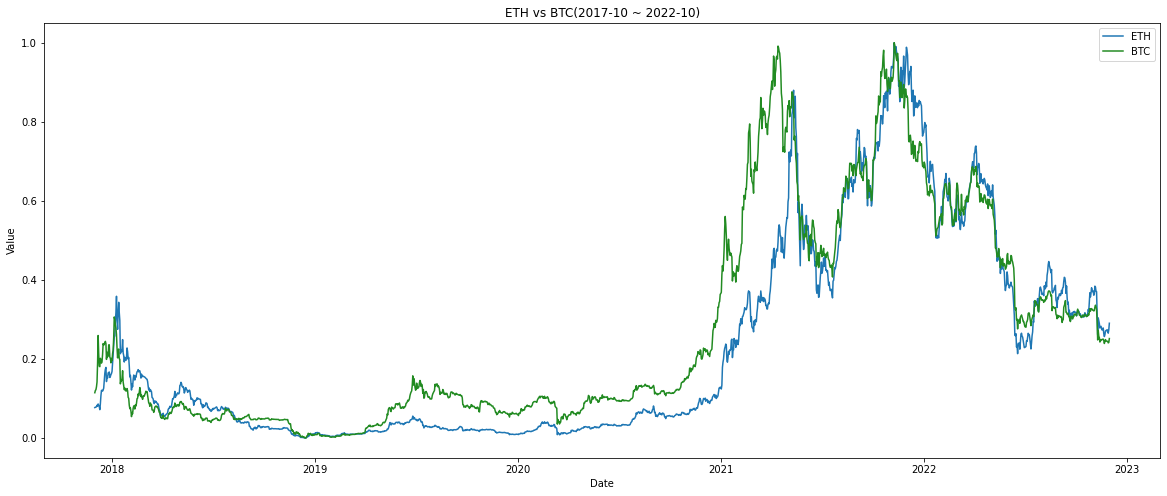

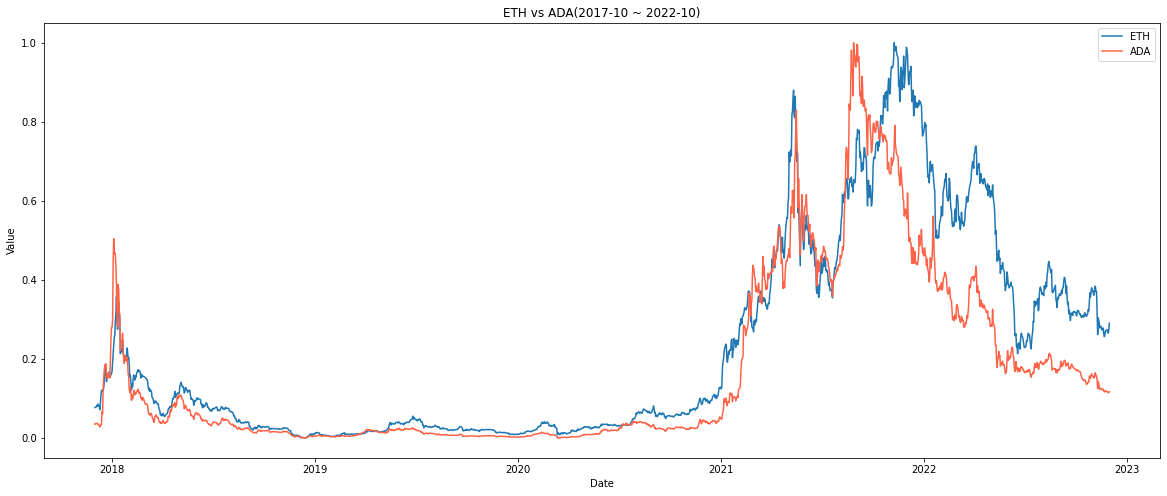

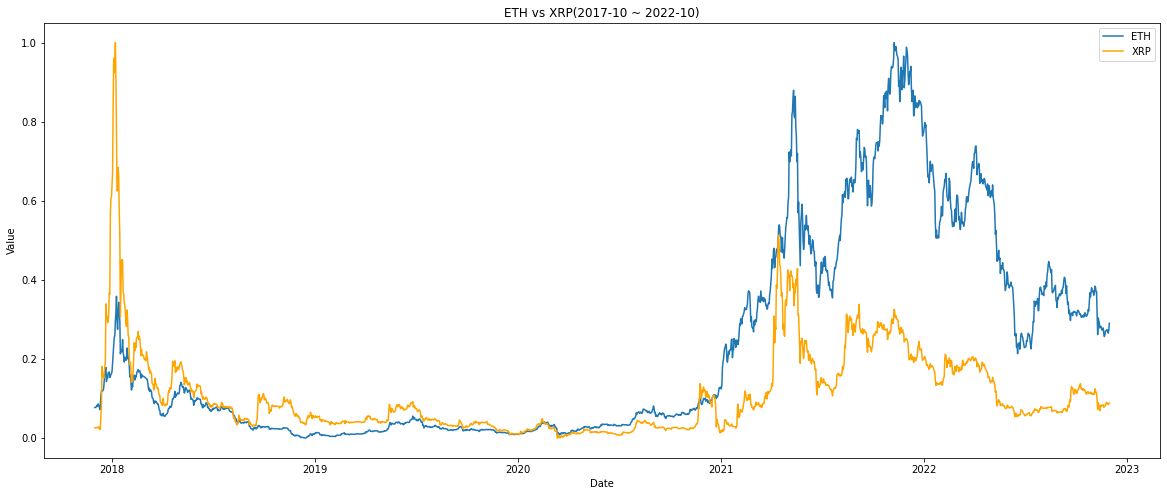

In [6]:
plt.figure(figsize=(20,8))
plt.plot(df_ETH['일자'], df_ETH['종가'], label = 'ETH')
plt.plot(df_BTC['일자'], df_BTC['종가'], label = 'BTC', color = 'forestgreen')
plt.title('ETH vs BTC(2017-10 ~ 2022-10)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(df_ETH['일자'], df_ETH['종가'], label = 'ETH')
plt.plot(df_ADA['일자'], df_ADA['종가'], label = 'ADA', color = 'tomato')
plt.title('ETH vs ADA(2017-10 ~ 2022-10)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(df_ETH['일자'], df_ETH['종가'], label = 'ETH')
plt.plot(df_XRP['일자'], df_XRP['종가'], label = 'XRP', color = 'orange')
plt.title('ETH vs XRP(2017-10 ~ 2022-10)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## train, test 데이터 분리

In [7]:
TEST_SIZE = 365
WINDOW_SIZE = 2

train_ETH = df_ETH[:-TEST_SIZE - WINDOW_SIZE]
test_ETH = df_ETH[-TEST_SIZE - WINDOW_SIZE:]

## train, valid, test 데이터셋 생성

In [8]:
def make_dataset(data, label, window_size):

  feature_list = []
  label_list = []

  for i in range(len(data) - window_size):
    feature_list.append(np.array(data.iloc[i:i + window_size]))
    label_list.append(np.array(label.iloc[i + window_size]))

  return np.array(feature_list), np.array(label_list)

In [9]:
def make_train(train):

  feature_cols = ['시가', '고가', '저가', '거래수', '거래량']
  label_cols = ['종가']
  
  train_feature = train[feature_cols]
  train_label = train[label_cols]
  train_feature, train_label = make_dataset(train_feature, train_label, WINDOW_SIZE)
  x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.3)

  return x_train, x_valid, y_train, y_valid

In [10]:
def make_test(test):

  feature_cols = ['시가', '고가', '저가', '거래수', '거래량']
  label_cols = ['종가']

  test_feature = test[feature_cols]
  test_label = test[label_cols]
  x_test, y_test = make_dataset(test_feature, test_label, WINDOW_SIZE)

  return x_test, y_test

In [11]:
x_train_ETH, x_valid_ETH, y_train_ETH, y_valid_ETH = make_train(train_ETH)
x_train_BTC, x_valid_BTC, y_train_BTC, y_valid_BTC = make_train(df_BTC)
x_train_ADA, x_valid_ADA, y_train_ADA, y_valid_ADA = make_train(df_ADA)
x_train_XRP, x_valid_XRP, y_train_XRP, y_valid_XRP = make_train(df_XRP)

#x_train = np.concatenate([x_train_ETH, x_train_BTC, x_train_ADA, x_train_XRP])
#x_valid = np.concatenate([x_valid_ETH, x_valid_BTC, x_valid_ADA, x_valid_XRP])
#y_train = np.concatenate([y_train_ETH, y_train_BTC, y_train_ADA, y_train_XRP])
#y_valid = np.concatenate([y_valid_ETH, y_valid_BTC, y_valid_ADA, y_valid_XRP])

x_train = x_train_ETH
x_valid = x_valid_ETH
y_train = y_train_ETH
y_valid = y_valid_ETH

x_test, y_test = make_test(test_ETH)

In [12]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, x_test.shape, y_test.shape

((1019, 2, 5), (438, 2, 5), (1019, 1), (438, 1), (365, 2, 5), (365, 1))

# 신경망 모델

## 모델 생성

In [13]:
epochs = 150
optimizer = Adam(0.001)

In [14]:
model1 = Sequential()
model1.add(LSTM(50, activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
model1.add(Dense(1))
model1.compile(loss = 'mse', optimizer = optimizer)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


## 학습 시작

In [15]:
filename = os.path.join('tmp', 'model1.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

start = time.time()
history1 = model1.fit(x_train, y_train, 
                    validation_data = (x_valid, y_valid),
                    epochs = epochs,
                    callbacks=[checkpoint],
                    verbose = 2)
print("\ntime :", time.time() - start)

Epoch 1/150

Epoch 1: val_loss improved from inf to 0.03305, saving model to tmp/model1.ckpt
32/32 - 4s - loss: 0.0615 - val_loss: 0.0330 - 4s/epoch - 115ms/step
Epoch 2/150

Epoch 2: val_loss improved from 0.03305 to 0.00991, saving model to tmp/model1.ckpt
32/32 - 0s - loss: 0.0238 - val_loss: 0.0099 - 222ms/epoch - 7ms/step
Epoch 3/150

Epoch 3: val_loss improved from 0.00991 to 0.00127, saving model to tmp/model1.ckpt
32/32 - 0s - loss: 0.0051 - val_loss: 0.0013 - 257ms/epoch - 8ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.00127 to 0.00100, saving model to tmp/model1.ckpt
32/32 - 0s - loss: 6.8357e-04 - val_loss: 9.9519e-04 - 235ms/epoch - 7ms/step
Epoch 5/150

Epoch 5: val_loss improved from 0.00100 to 0.00078, saving model to tmp/model1.ckpt
32/32 - 0s - loss: 5.2971e-04 - val_loss: 7.7868e-04 - 252ms/epoch - 8ms/step
Epoch 6/150

Epoch 6: val_loss improved from 0.00078 to 0.00071, saving model to tmp/model1.ckpt
32/32 - 0s - loss: 4.8341e-04 - val_loss: 7.0552e-04 - 22

Text(0, 0.5, 'Loss')

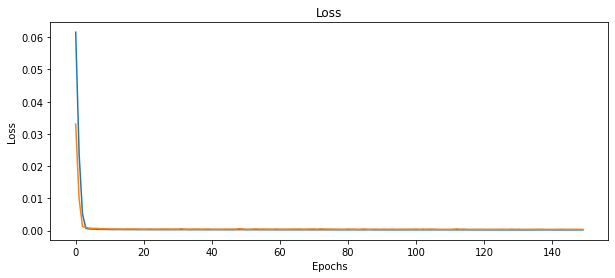

In [16]:
plt.figure(figsize =(10,4))
plt.plot(history1.history['loss'], label = 'Training Loss')
plt.plot(history1.history['val_loss'], label = 'Validation Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

## 모델 예측 결과

In [17]:
model1.load_weights(filename)
y_pred1 = model1.predict(x_test)
y_pred1.shape

12/12 [==============================] - 0s 2ms/step


(365, 1)

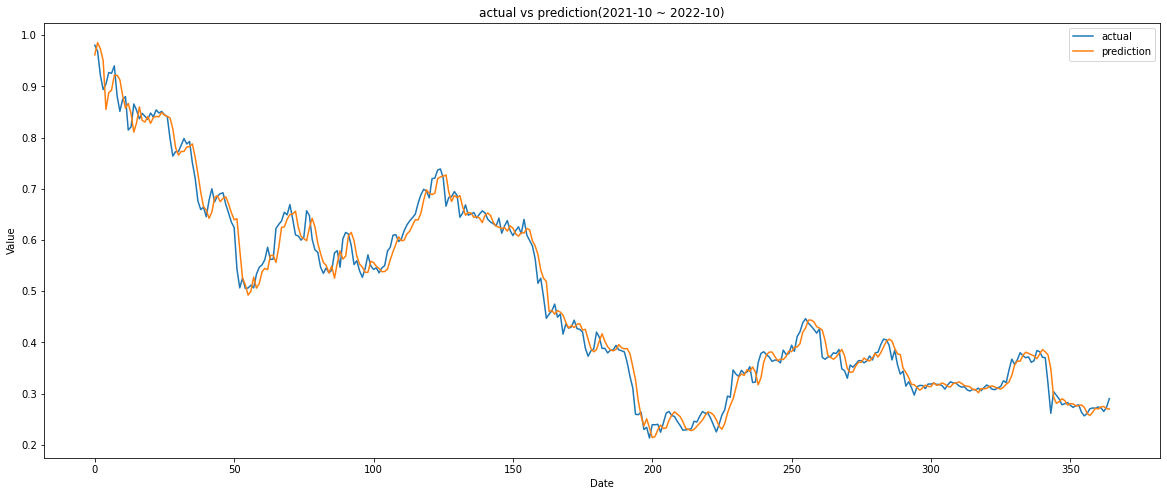

In [18]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='actual')
plt.plot(y_pred1, label='prediction')
plt.title('actual vs prediction(2021-10 ~ 2022-10)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [19]:
money_AI = y_test[20]
AI_test = np.zeros(shape=(TEST_SIZE - 20))
status = 0
print('시작 : ', format(int(y_test[19] * max_ETH), ','),'\n')
for i in range(20, TEST_SIZE - 1):
  print(i+1,'일, 전날 예측값 : ', format(int(y_pred1[i] * max_ETH), ','), ', 실제값 : ', format(int(y_test[i] * max_ETH), ','), ', 다음날 예측값 : ', format(int(y_pred1[i+1] * max_ETH), ','))
  if(y_pred1[i+1] > y_test[i]):
    if(status == 0):
      status = 1
      temp = money_AI
      print('AI : BUY, money : ', format(int(money_AI * max_ETH), ','))
    elif(status == 1):
      money_AI = money_AI * (y_test[i] / y_test[i-1])
      print('AI : HOLD, money : ', format(int(money_AI * max_ETH), ','))
  else:
    if(status == 0):
      print('AI : NOP, money : ', format(int(money_AI * max_ETH), ','))
    elif(status == 1):
      status = 0
      money_AI = money_AI * (y_test[i] / y_test[i-1])
      print('AI : SELL, money : ', format(int(money_AI * max_ETH), ','))
      print('AI : 손익 : ', format(int((money_AI - temp) * max_ETH), ','))
  print('\n')
  AI_test[i-20] = money_AI

if(status == 1):
  money_AI = money_AI * (y_test[i] / y_test[i-1])
AI_test[TEST_SIZE - 21] = money_AI

dif1 = float((y_test[TEST_SIZE - 1]/y_test[20])*100 - 100)
dif2 = float((money_AI/y_test[20])*100 - 100)
print("\n홀드 : ", format(int(y_test[TEST_SIZE - 1] * max_ETH), ','), ', 최종손익 : ', format(int((y_test[TEST_SIZE - 1] - y_test[20]) * max_ETH), ','), f'({dif1:.2f}%)')
print('AI 매매 : ', format(int(money_AI * max_ETH), ','), ', 최종손익 : ', format(int((money_AI - y_test[20]) * max_ETH), ','), f'({dif2:.2f}%)')

시작 :  4,850,469 

21 일, 전날 예측값 :  4,805,054 , 실제값 :  4,921,627 , 다음날 예측값 :  4,869,961
AI : NOP, money :  4,921,627


22 일, 전날 예측값 :  4,869,961 , 실제값 :  4,877,915 , 다음날 예측값 :  4,883,589
AI : BUY, money :  4,921,627


23 일, 전날 예측값 :  4,883,589 , 실제값 :  4,957,206 , 다음날 예측값 :  4,879,499
AI : SELL, money :  5,001,627
AI : 손익 :  80,000


24 일, 전날 예측값 :  4,879,499 , 실제값 :  4,922,643 , 다음날 예측값 :  4,927,525
AI : BUY, money :  5,001,627


25 일, 전날 예측값 :  4,927,525 , 실제값 :  4,939,924 , 다음날 예측값 :  4,898,085
AI : SELL, money :  5,019,186
AI : 손익 :  17,558


26 일, 전날 예측값 :  4,898,085 , 실제값 :  4,902,312 , 다음날 예측값 :  4,883,768
AI : NOP, money :  5,019,186


27 일, 전날 예측값 :  4,883,768 , 실제값 :  4,880,965 , 다음날 예측값 :  4,865,967
AI : NOP, money :  5,019,186


28 일, 전날 예측값 :  4,865,967 , 실제값 :  4,630,896 , 다음날 예측값 :  4,741,969
AI : BUY, money :  5,019,186


29 일, 전날 예측값 :  4,741,969 , 실제값 :  4,433,688 , 다음날 예측값 :  4,527,854
AI : HOLD, money :  4,805,442


30 일, 전날 예측값 :  4,527,854 , 실제값 :  4,484,515 , 다음날 예

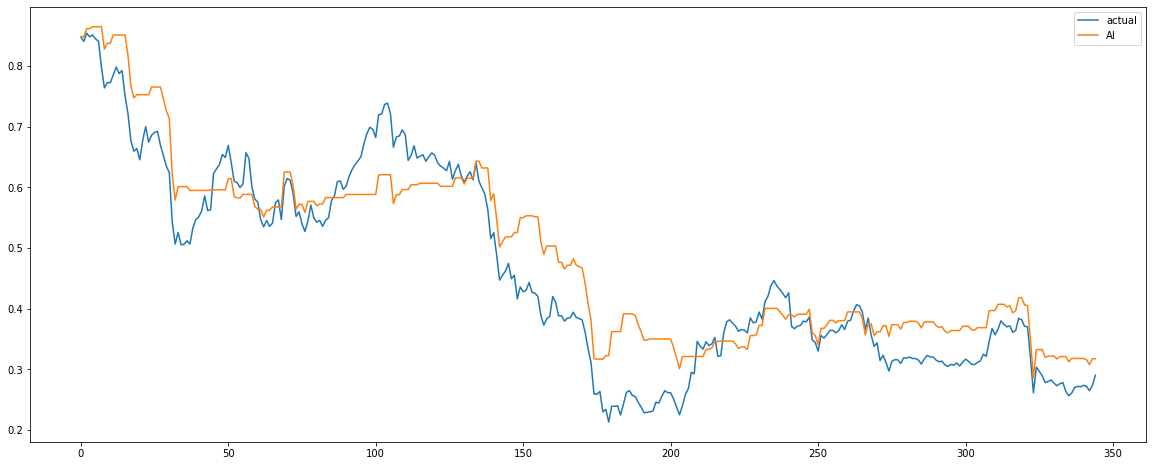

In [20]:
plt.figure(figsize=(20, 8))
plt.plot(y_test[20:], label='actual')
plt.plot(AI_test, label='AI')
plt.legend()
plt.show()

#이동평균선 매매와 AI 매매 비교


In [21]:
def avg_n(data, n):
  result = np.zeros(shape=(TEST_SIZE - n + 1))

  for i in range(n - 1, TEST_SIZE):
    sum = 0
    for j in range(n):
      sum = sum + data[i - j]
    avg = sum/n
    result[i - n + 1] = avg
  return result

In [22]:
avg_5 = avg_n(y_test, 5)
avg_20 = avg_n(y_test, 20)

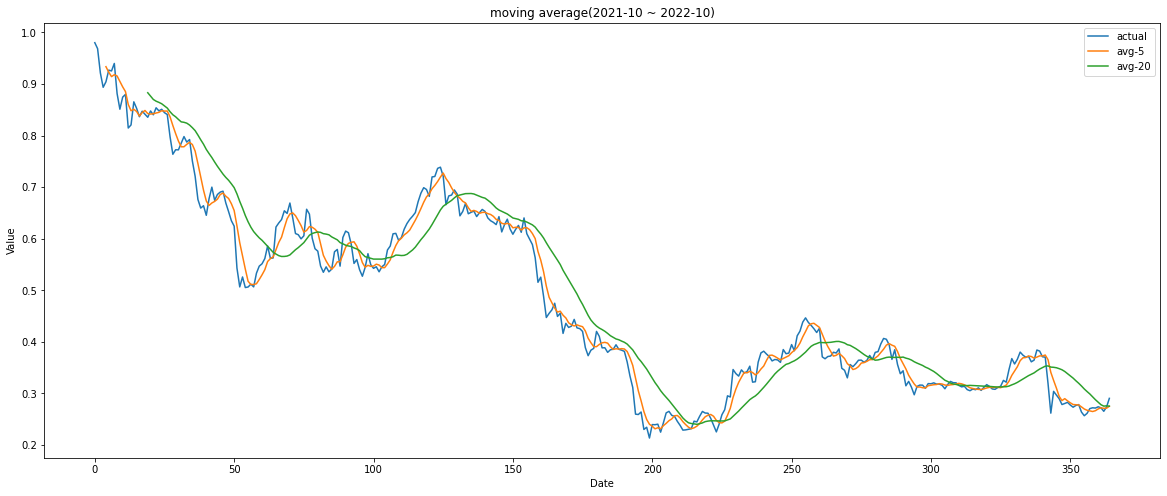

In [23]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='actual')
plt.plot(range(4, TEST_SIZE), avg_5, label='avg-5')
plt.plot(range(19, TEST_SIZE), avg_20, label='avg-20')
plt.title('moving average(2021-10 ~ 2022-10)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [24]:
money_AI = y_test[20]
money_AVG = y_test[20]
AI_test = np.zeros(shape=(TEST_SIZE - 21))
AVG_test = np.zeros(shape=(TEST_SIZE - 21))
state = 0
state2 = 0

print('시작 : ', format(int(y_test[19] * max_ETH), ','),'\n')

for i in range(20, TEST_SIZE - 1):

  print(i+1,'일, 전날 예측값 : ', format(int(y_pred1[i] * max_ETH), ','), ', 실제값 : ', format(int(y_test[i] * max_ETH), ','), ', 다음날 예측값 : ', format(int(y_pred1[i+1] * max_ETH), ','))

  if(state2 == 0):

    if(avg_5[i - 4] - avg_20[i - 19] > 0 and avg_5[i - 5] - avg_20[i - 20] < 0):
      state2 = 1
      temp2 = money_AVG
      print('AVG : BUY, money : ', format(int(money_AVG * max_ETH), ','))

    else:
      print('AVG : NOP, money : ', format(int(money_AVG * max_ETH), ','))

  elif(state2 == 1):

    if(avg_5[i - 4] - avg_20[i - 19] < 0 and avg_5[i - 5] - avg_20[i - 20] > 0):
      state2 = 0
      money_AVG = money_AVG * (y_test[i] / y_test[i-1])
      print('AVG : SELL, money : ', format(int(money_AVG * max_ETH), ','))
      print('AVG : 손익 : ', format(int((money_AVG - temp2) * max_ETH), ','))

    else:
      money_AVG = money_AVG * (y_test[i] / y_test[i-1])
      print('AVG : HOLD, money : ', format(int(money_AVG * max_ETH), ','))

  if(y_pred1[i+1] > y_test[i]):

    if(state == 0):
      state = 1
      temp = money_AI
      print('AI : BUY, money : ', format(int(money_AI * max_ETH), ','))
    
    elif(state == 1):
      money_AI = money_AI * (y_test[i] / y_test[i-1])
      print('AI : HOLD, money : ', format(int(money_AI * max_ETH), ','))

  else:

    if(state == 0):
      print('AI : NOP, money : ', format(int(money_AI * max_ETH), ','))

    elif(state == 1):
      state = 0
      money_AI = money_AI * (y_test[i] / y_test[i-1])
      print('AI : SELL, money : ', format(int(money_AI * max_ETH), ','))
      print('AI : 손익 : ', format(int((money_AI - temp) * max_ETH), ','))

  print('\n')
  AI_test[i-20] = money_AI
  AVG_test[i-20] = money_AVG

dif1 = float((y_test[TEST_SIZE - 1]/y_test[20])*100 - 100)
dif2 = float((money_AI/y_test[20])*100 - 100)
dif3 = float((money_AVG/y_test[20])*100 - 100)
print("홀드 : ", format(int(y_test[TEST_SIZE - 1] * max_ETH), ','), ', 최종손익 : ', format(int((y_test[TEST_SIZE - 1] - y_test[20]) * max_ETH), ','), f'({dif1:.2f})')
print('AI 매매 : ', format(int(money_AI * max_ETH), ','), ', 최종손익 : ', format(int((money_AI - y_test[20]) * max_ETH), ','), f'({dif2:.2f})')
print('이동평균선 매매 : ', format(int(money_AVG * max_ETH), ','), ', 최종손익 : ', format(int((money_AVG - y_test[20]) * max_ETH), ','), f'({dif3:.2f})')

시작 :  4,850,469 

21 일, 전날 예측값 :  4,805,054 , 실제값 :  4,921,627 , 다음날 예측값 :  4,869,961
AVG : NOP, money :  4,921,627
AI : NOP, money :  4,921,627


22 일, 전날 예측값 :  4,869,961 , 실제값 :  4,877,915 , 다음날 예측값 :  4,883,589
AVG : NOP, money :  4,921,627
AI : BUY, money :  4,921,627


23 일, 전날 예측값 :  4,883,589 , 실제값 :  4,957,206 , 다음날 예측값 :  4,879,499
AVG : NOP, money :  4,921,627
AI : SELL, money :  5,001,627
AI : 손익 :  80,000


24 일, 전날 예측값 :  4,879,499 , 실제값 :  4,922,643 , 다음날 예측값 :  4,927,525
AVG : NOP, money :  4,921,627
AI : BUY, money :  5,001,627


25 일, 전날 예측값 :  4,927,525 , 실제값 :  4,939,924 , 다음날 예측값 :  4,898,085
AVG : NOP, money :  4,921,627
AI : SELL, money :  5,019,186
AI : 손익 :  17,558


26 일, 전날 예측값 :  4,898,085 , 실제값 :  4,902,312 , 다음날 예측값 :  4,883,768
AVG : NOP, money :  4,921,627
AI : NOP, money :  5,019,186


27 일, 전날 예측값 :  4,883,768 , 실제값 :  4,880,965 , 다음날 예측값 :  4,865,967
AVG : NOP, money :  4,921,627
AI : NOP, money :  5,019,186


28 일, 전날 예측값 :  4,865,967 , 실제값 :  4,630,

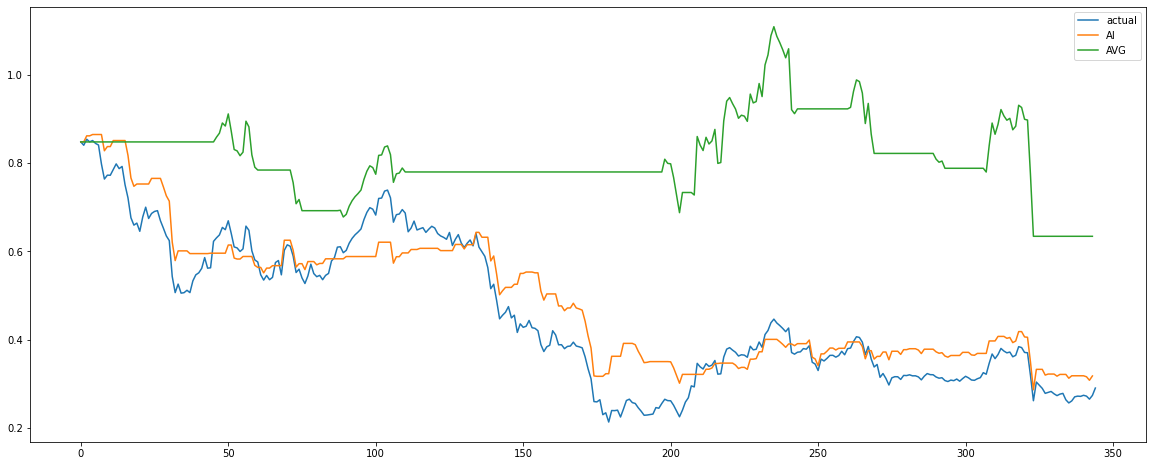

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(y_test[20:], label='actual')
plt.plot(AI_test, label='AI')
plt.plot(AVG_test, label='AVG')
plt.legend()
plt.show()